# DSA-Radius Basic Usage Tutorial 
Updated 6/17/2021

## Contents
- [Quick Start](#quick_start)
- [Simulation Output & Metadata](#dsa_df)
- [Target Metadata](#meta)
  - [Using Coordinates](#coords)
  - [Setting Initial Conditions](#initial_conditions)
  - [Using Different Moves](#moves)
  - [Adding/Removing Photometry](#photometry)
    - [Adding Photometry](#adding)
    - [Local Photometry](#local)
    - [Removing Photometry](#removing)
  - [Target Metadata Summary](#meta_summary)
- [Changing the Isochrone Model](#isochrone)
- [Changing the Interpolation Method](#interp_method)
- [Making Basic Plots](#plot)
- [Miscellaneous](#misc)
  - [Measured Photometry Kwargs](#meas_phot_kwargs)
  - [Set Extinction to Zero](#zero_extinction)

## Quick Start <a id='quick_start'></a>

The radius module of `dsa` is used to estimate stellar radii and other parameters. We'll run through a quick example to demonstrate basic capabilities before taking a look at some of the more advanced features below.

First, we'll import `Estimate` from `dsa.radius` and initialize it for our target. In this example, we'll use K2-33.

In [1]:
from dsa.radius import Estimate

target = 'K2-33'
est = Estimate(target)

Now, we'll run a quick MCMC simulation using 16 walkers for 250 steps. `dsa.radius` uses the `emcee` package to run the simulations, and as such, returns an `emcee.EnsemberSampler` object, which we'll name `sampler`.

A typical simulation should use more steps and more walkers depending on the problem being solved. The few steps we're using here let us run a reasonably quick simulation to get the point across. 

**Note: the first few steps will be much slower than the rest of the simulation so don't be alarmed.**

In [2]:
nwalkers = 16
nsteps = 250

sampler = est.run(nwalkers, nsteps)


running MCMC for K2-33:


100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


Now that we've run the simulation, we're able to use `sampler` in every way a typical `EnsembleSampler` object can be used. See the [`emcee` documentation](https://emcee.readthedocs.io/en/stable/) for more information. 

For this example, we're going to use one of the built-in functions of the `Estimate` class to extract the posterior distributions for our parameters. Briefly, `posterior` contains the quotable values and uncertainties of the estimated stellar parameters, `photometry` contains the measured and estimated photometry (e.g., magnitudes and fluxes), and `chains` contains the full posterior distributions of the stellar parameters. See the [following section](#dsa_df) for a more in depth look at the simulation output.

In [3]:
posterior, photometry, chains = est.posterior(sampler)


extracting posterior for K2-33:

calculating max log probability:


100%|██████████| 4000/4000 [01:04<00:00, 62.24it/s]



getting radius and Teff chains:


100%|██████████| 4000/4000 [00:47<00:00, 83.92it/s]


## Simulation Output & Metadata <a id='dsa_df'></a>

Each output object is a `DSADataFrame` which is a subclass of `pandas.DataFrame` that has been constructed just for DSA-related output. I think `DataFrame` objects work really well in the background during the simulation, but I find them lacking to describe the data contained within them, especially to someone unfamiliar with the simulation output.

A `DSADataFrame` works exactly the same as a normal `DataFrame` except that it can handle more metadata than its generic counterpart. All three of the output objects contain the same general information about the simulation which can be accessed via `<object>.metadata`. However, the special thing about these `DSADataFrame` objects is that they can be directly translated to `astropy.table.Table` objects which can display units and data types, or contain descriptions and other information that a `DataFrame` cannot. `astropy` already has built-in functions to convert a `DataFrame` to a `Table`, but `DSADataFrame` adds all of the relevant metadata for that particular object.

Let's look at `posterior` first. It contains median (50th percentile) and maximum-probability estimated fit values and uncertainties for the stellar parameters. To convert it to a `Table` (and to access its attributes after that), we need to store it in another variable (here arbitrarily called `apost`).

In [4]:
apost = posterior.to_astropy()
apost

quoted_value,age,mass,Av,f,radius,Teff,density
,Myr,solMass,mag,mag,solRad,K,solMass / solRad3
str15,float64,float64,float64,float64,float64,float64,float64
median,600.92,0.711249,1.28085,0.45733,0.77083,3982.39,1.599
max_probability,22.932,0.782344,1.51351,0.16492,0.988339,3674.93,0.810364
uncertainty,794.296,0.077175,1.02691,0.25837,0.133559,344.92,0.670843
+,1029.94,0.0634808,1.16590,0.32132,0.135839,446.529,0.81986
-,558.647,0.0908691,0.88792,0.19542,0.131278,243.31,0.521826


This is actually a transposed representation from its original `DSADataFrame`. This is just to make it easier to show the units of each stellar parameter. We can look at any column for more information, so we'll take this as an opportunity to learn what the fit parameters are.

In [5]:
print('age:', apost['age'].description)
print('mass:', apost['mass'].description)
print('Av:', apost['Av'].description)
print('f:', apost['f'].description)

age: estimated stellar age
mass: estimated stellar mass
Av: estimated V-band extinction
f: underestimation of measured magnitude uncertainties


Also, a description of what each index means can be found via `apost['quoted_value'].description`.

In [6]:
apost['quoted_value'].description

'median: 50th percentile; max_probability: maximum value calculated from the log-probability function; uncertainty: average of upper and lower confidence intervals;                    +: upper confidence interval calculated as difference between 84th and 50th percentiles; -: lower confidence interval calculated as difference between 50th and 16th percentiles'

You can access the same metadata that would be in `posterior.metadata` via `apost.meta` as well. Many of these parameters will be discussed in later sections.

In [7]:
apost.meta

{'target': 'K2-33',
 'coordinates': None,
 'isochrone': 'mag',
 'interp_method': 'true',
 'use_synphot': False,
 'nwalkers': 16,
 'nsteps': 250,
 'discard': 0,
 'thin': 1,
 'mean_acceptance_frac': 0.406,
 'median_autocorr_time': 26.573,
 'date': '20210604',
 'sim_runtime': '00:02:02',
 'posterior_extract_time': '00:01:56'}

Although `DSADataFrame` objects were created to make metadata visualization easier, `apost` is now a `Table` object, so you could exclusively work with it this way if that's what you prefer. However, there are some functions that take the simulation output as arguments (e.g., plotting) that may not work properly if given a `Table` object instead of a `DataFrame` or `DSADataFrame`. 

Next is `photometry` which contains all of the observed and estimated information relating to the photometry in each passband. We'll view this as a `Table` object, and it serves as a goodness-of-fit metric for the simulation. There is a lot of information contained here, but the most important are the measured magnitudes/fluxes and the model magnitudes/fluxes. Most measured values are taken from [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR).

In [8]:
aphot = photometry.to_astropy()
aphot

band,apparent_magnitude,apparent_magnitude_error,ABSOLUTE_MAGNITUDE,ABSOLUTE_MAGNITUDE_ERROR,flux,flux_error,parallax,parallax_error,zeropoint_flux,wavelength,system,isochrone_analog,MEDIAN_ABSOLUTE_MAGNITUDE,MEDIAN_ABSOLUTE_MAGNITUDE_ERROR,median_apparent_magnitude,median_apparent_magnitude_error,median_flux,median_flux_error,median_percent_error,MAX_PROBABILITY_ABSOLUTE_MAGNITUDE,MAX_PROBABILITY_ABSOLUTE_MAGNITUDE_ERROR,max_probability_apparent_magnitude,max_probability_apparent_magnitude_error,max_probability_flux,max_probability_flux_error,max_probability_percent_error
,mag,mag,mag,mag,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),arcsec,arcsec,erg / (Angstrom cm2 s),Angstrom,,,mag,mag,mag,mag,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),%,mag,mag,mag,mag,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),%
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2mass_jmag,11.09500,0.02300,5.37952,0.02406,1.14642e-14,2.42855e-16,7.19290e-03,2.34000e-05,3.14300e-10,12350,VEGA,2mass_jmag,5.64949,0.45796,11.36497,0.45802,8.94040e-15,3.77150e-15,22.01,5.42813,0.16666,11.14361,0.16681,1.09622e-14,1.68422e-15,4.38
2mass_hmag,10.33200,0.02200,4.61652,0.02311,8.42609e-15,1.70736e-16,7.19290e-03,2.34000e-05,1.14400e-10,16620,VEGA,2mass_hmag,4.81384,0.45791,10.52932,0.45797,7.02584e-15,2.96353e-15,16.62,4.57580,0.16653,10.29128,0.16668,8.74813e-15,1.34296e-15,3.82
2mass_kmag,10.02600,0.01900,4.31052,0.02027,4.20411e-15,7.35704e-17,7.19290e-03,2.34000e-05,4.30600e-11,21590,VEGA,2mass_kmag,4.56096,0.45778,10.27644,0.45783,3.33808e-15,1.40760e-15,20.60,4.25460,0.16616,9.97008,0.16631,4.42630e-15,6.77994e-16,5.29
gaia_gmag,14.13351,0.00287,8.41803,0.00762,5.56168e-15,1.46964e-17,7.19290e-03,2.34000e-05,2.50386e-09,5822.4,VEGA,gaia_gmag,8.22366,0.45739,13.93913,0.45745,6.65206e-15,2.80268e-15,19.61,8.52108,0.16509,14.23656,0.16524,5.05810e-15,7.69812e-16,9.05
gaia_bpmag,15.73287,0.00484,10.01739,0.00856,2.07662e-15,9.26290e-18,7.19290e-03,2.34000e-05,4.07852e-09,5035.8,VEGA,gaia_bpmag,9.30882,0.45741,15.02430,0.45746,3.98826e-15,1.68042e-15,92.06,9.99318,0.16514,15.70866,0.16529,2.12344e-15,3.23264e-16,2.25
gaia_rpmag,12.91242,0.00406,7.19694,0.00815,8.67959e-15,3.24405e-17,7.19290e-03,2.34000e-05,1.26902e-09,7620,VEGA,gaia_rpmag,7.19503,0.45740,12.91051,0.45746,8.69487e-15,3.66344e-15,0.18,7.32439,0.16512,13.03987,0.16527,7.71830e-15,1.17485e-15,11.08
sdss_gmag,16.45200,0.00400,10.73652,0.00812,1.30943e-15,4.82412e-18,7.19290e-03,2.34000e-05,4.98749e-09,4671.8,AB,sdss_gmag,9.98919,0.45740,15.70467,0.45746,2.60624e-15,1.09810e-15,99.04,10.73272,0.16511,16.44820,0.16527,1.31402e-15,2.00014e-16,0.35
sdss_rmag,14.84500,0.00400,9.12952,0.00812,3.32929e-15,1.22656e-17,7.19290e-03,2.34000e-05,2.88637e-09,6141.1,AB,sdss_rmag,8.38264,0.45740,14.09812,0.45746,6.62375e-15,2.79080e-15,98.95,9.06230,0.16511,14.77778,0.16527,3.54193e-15,5.39137e-16,6.39


Lastly, `chains` holds the flattened posterior distributions for every parameter. The lengths of the chains shorten if they are thinned with the `thin` argument or some of the beginning samples are discarded (i.e., burned-in) with the `discard` argument.

In [9]:
achains = chains.to_astropy()
achains

age,mass,Av,f,radius,Teff,density
Myr,solMass,mag,mag,solRad,K,solMass / solRad3
float64,float64,float64,float64,float64,float64,float64
721.848,1.04203,0.00601,0.04363,1.03515,5568.74,0.939441
659.022,1.19216,0.17987,0.13537,1.19175,6139.89,0.704335
695.83,1.07443,0.03734,0.24152,1.06825,5693.93,0.881362
726.639,1.01561,0.08116,0.14095,1.00758,5465.41,0.992853
672.642,1.00628,0.11445,0.28552,0.996311,5427.93,1.0175
736.559,1.11525,0.19088,0.13574,1.11314,5851.91,0.808592
689.67,1.0824,0.04641,0.21309,1.07637,5724.62,0.86797
755.273,1.10161,0.13503,0.14303,1.09922,5800.44,0.82942


## Target Metadata <a id='meta'></a>

The built-in `Target` class gives us a convenient infrastructure to change or view the metadata specific to our target in the simulation.

There are four main attribute categories that can be changed, and each may contain additional modifiable attributes.

The most basic way the `Target` class can be used is by initializing it with only a name.

In [10]:
from dsa.radius import Target

target = Target('K2-33')

Now, `target` has been redifined as a `Target` object instead of just the target name string as it was previously. It can be used in the estimation in exactly the same way as before, i.e., `est = Estimate(target)`. In this case, since we only set the `Target` object with a target name, it behaves the same within the simulation as setting `target = 'K2-33'`. 

### Using Coordinates <a id='coords'></a>

It's possible to pass coordinates for your target if you don't have a name that exists in Vizier. When you initialize a `Target` object, you can pass either an `astropy.coordinates.SkyCoord` object, or you can pass the coordinates as a tuple and any keyword arguments that you would use to create a `SkyCoord` object. See the [astropy documentation](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) for more details.

We still need to give it a name, but now we can call it whatever we want since it won't be used by Vizier.

Let's create an arbitrary target called "my_target" which we'll say has a right ascension and declination of 100 degrees and  -50 degrees, respectively. Once it's initialized, we can treat it exactly as any of the other `Target` objects we create in this tutorial.

In [11]:
my_target = Target('my_target', (100, -50), unit='deg')
my_target.coords

<SkyCoord (ICRS): (ra, dec) in deg
    (100., -50.)>

### Setting Initial Conditions <a id='initial_conditions'></a>

The second metadata category includes all of the initial/boundary conditions for the simulation. There are four initial condition attributes that we can manipulate: bounds, prior, position, and perturbation. 

- *Bounds:* the hard boundaries of the simulation, beyond which the log_probability goes to $-\infty$ (i.e., the answer cannot lie outside the bounds). Each fit parameter (age, mass, $A_v$, f) has upper and lower bounds that can be easily changed if necessary. Default bounds for age and mass are constrained by the isochronal model that is used by the simulation. Default bounds for $A_v$ and f are loose physical constraints. Bounds are given as (upper, lower) pairs.

- *Prior:* the Gaussian (normal) distribution for any of the fit parameters, as well as for effective temperature, which is effectively applied as a prior to age and mass as these two parameters are used to interpolate $T_{eff}$ from the model grid. Priors are given as ($\mu$, $\sigma$) pairs, where $\mu$ and $\sigma$ are the mean and standard deviation of the distribution, respectively. Priors are all user-defined, thus none are applied by default.

- *Position and Perturbation:* these attributes combine to form the initial position for each fit parameter of the MCMC simulation. The position of each walker (in parameter space) is varied randomly from a normal distribution centered on the perturbation for each parameter.

For reference, we can view the default initial conditions in `target`.

In [12]:
target.initial_conditions

bounds       prior position perturbation
target parameter                                                  
K2-33  age        (1.0, 10000.0)  (nan, nan)      700           35
       mass         (0.09, 2.45)  (nan, nan)        1          0.2
       Av             (0.0, 3.0)  (nan, nan)        0          0.2
       f              (0.0, 2.0)  (nan, nan)        0          0.2
       Teff           (nan, nan)  (nan, nan)      NaN          NaN

A look at the estimated photometry, and the wide uncertainty in our fit parameters, shows the simulation was far from accurate in giving us an answer. Fortunately, we can use any prior knowledge we have to modify the prior and give the simulation a better chance at convergence.

For K2-33, we know $age \sim 11 \pm 3$ Myr, $A_v \sim 0.75 \pm 0.2$ mag, and $T_{eff} \sim 3540 \pm 70$ K. For the purposes of this tutorial, we can also lower the initial age position to $200$ Myr. These initial conditions are set using nested dictionaries for each attribute, and after we set them, we can check them again to make sure they've been applied.

In [13]:
target.initial_conditions = {
    'prior' : {
        'age':(11, 3),
        'Av':(0.75, 0.2),
        'Teff':(3540, 70)
        },
    'position' : {
        'age':200
        }
    }

target.initial_conditions

bounds        prior position perturbation
target parameter                                                   
K2-33  age        (1.0, 10000.0)      (11, 3)      200           35
       mass         (0.09, 2.45)   (nan, nan)        1          0.2
       Av             (0.0, 3.0)  (0.75, 0.2)        0          0.2
       f              (0.0, 2.0)   (nan, nan)        0          0.2
       Teff           (nan, nan)   (3540, 70)      NaN          NaN

Now we can run the same simulation as before, with 16 walkers and 250 steps, but with our new `Target` object as `target`.

In [14]:
est = Estimate(target)

sampler = est.run(16, 250)

posterior, photometry, chains = est.posterior(sampler)


running MCMC for K2-33:


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]



extracting posterior for K2-33:

calculating max log probability:


100%|██████████| 4000/4000 [01:01<00:00, 65.21it/s]



getting radius and Teff chains:


100%|██████████| 4000/4000 [00:46<00:00, 86.73it/s] 


We'll look at `posterior` and `photometry` as their native `DSADataFrame` objects, but they can always be viewed as `astropy.table.Table` objects as explained in the [above section](#dsa_df).

In [15]:
posterior

,median,max_probability,uncertainty,+,-
parameter,,,,,
age,12.8498,11.1773,4.28657,6.04677,2.52638
mass,0.591574,0.575914,0.0690733,0.0793507,0.0587958
Av,0.924243,1.05579,0.343631,0.188227,0.499035
f,0.172055,0.0949079,0.106491,0.146181,0.0668013
radius,0.994719,1.02757,0.0597408,0.0501714,0.0693102
Teff,3494.86,3482.18,58.1804,73.7788,42.582
density,0.601245,0.53079,0.150023,0.193959,0.106087


In [16]:
photometry

,apparent_magnitude,apparent_magnitude_error,ABSOLUTE_MAGNITUDE,ABSOLUTE_MAGNITUDE_ERROR,flux,flux_error,parallax,parallax_error,zeropoint_flux,wavelength,...,median_flux,median_flux_error,median_percent_error,MAX_PROBABILITY_ABSOLUTE_MAGNITUDE,MAX_PROBABILITY_ABSOLUTE_MAGNITUDE_ERROR,max_probability_apparent_magnitude,max_probability_apparent_magnitude_error,max_probability_flux,max_probability_flux_error,max_probability_percent_error
band,,,,,,,,,,,,,,,,,,,,,
2mass_jmag,11.095,0.023,5.37952,0.0240604,1.14642e-14,2.42855e-16,0.0071929,2.34e-05,3.143e-10,12350,...,1.13114e-14,1.81143e-15,1.33334,5.36722,0.0979102,11.0827,0.0981647,1.15948e-14,1.04832e-15,1.13922
2mass_hmag,10.332,0.022,4.61652,0.0231064,8.42609e-15,1.70736e-16,0.0071929,2.34e-05,1.144e-10,16620,...,8.33922e-15,1.33447e-15,1.03091,4.5838,0.0976801,10.2993,0.0979352,8.68388e-15,7.83301e-16,3.05942
2mass_kmag,10.026,0.019,4.31052,0.0202708,4.20411e-15,7.35704e-17,0.0071929,2.34e-05,4.306e-11,21590,...,4.12696e-15,6.59064e-16,1.83507,4.27854,0.0970485,9.99402,0.0973052,4.32977e-15,3.8804e-16,2.98898
gaia_gmag,14.1335,0.002869,8.41803,0.00762462,5.56168e-15,1.46964e-17,0.0071929,2.34e-05,2.50386e-09,5822.39,...,5.32141e-15,8.44814e-16,4.32005,8.51665,0.0952136,14.2321,0.0954753,5.07874e-15,4.46605e-16,8.68331
gaia_bpmag,15.7329,0.004843,10.0174,0.00856495,2.07662e-15,9.2629e-18,0.0071929,2.34e-05,4.07852e-09,5035.75,...,2.122e-15,3.36969e-16,2.18518,10.098,0.0952936,15.8135,0.095555,1.92799e-15,1.69681e-16,7.15743
gaia_rpmag,12.9124,0.004058,7.19694,0.00814684,8.67959e-15,3.24405e-17,0.0071929,2.34e-05,1.26902e-09,7619.96,...,8.15382e-15,1.29466e-15,6.05761,7.29495,0.0952569,13.0104,0.0955185,7.93041e-15,6.97684e-16,8.63152
sdss_gmag,16.452,0.004,10.7365,0.00811811,1.30943e-15,4.82412e-18,0.0071929,2.34e-05,4.98749e-09,4671.78,...,1.51228e-15,2.40116e-16,15.4912,10.7073,0.0952544,16.4228,0.095516,1.3451e-15,1.18333e-16,2.724
sdss_rmag,14.845,0.004,9.12952,0.00811811,3.32929e-15,1.22656e-17,0.0071929,2.34e-05,2.88637e-09,6141.12,...,3.21486e-15,5.1045e-16,3.43712,9.26707,0.0952544,14.9826,0.095516,2.93313e-15,2.58038e-16,11.8994
sdss_imag,13.668,0.001,7.95252,0.00713468,6.67444e-15,6.14739e-18,0.0071929,2.34e-05,1.95711e-09,7457.89,...,7.91247e-15,1.25601e-15,18.5487,7.8112,0.0951757,13.5267,0.0954375,7.60227e-15,6.68249e-16,13.9012


It's clear that the prior made a difference, especially looking at the estimated fit parameters.

### Using Different Moves <a id='moves'></a>

Also built into the `Target` infrastructure is the ability to use different ensemble moves. A good description of what these are and their basic usage can be found in the [`emcee` moves tutorial](https://emcee.readthedocs.io/en/stable/tutorials/moves/). All of the available moves and their references in the literature can be found in [this section](https://emcee.readthedocs.io/en/stable/user/moves/) of the `emcee` documentation.

`dsa.radius` gives the ability to use four of these moves: `StretchMove`, `DEMove`, `DESnookerMove`, and `KDEMove`, all from `emcee`. They can be accessed via the keywords `"stretch"`, `"DE"`, `"snooker"`, and `"KDE"`, respectively. The keywords are not case-sensitive. Along with a keyword, a weight must be applied to each move. Any arguments can also be given to each move function as you would with `emcee`. 

`StretchMove` with a weight of 1.0 is the default move.

In [17]:
target.moves

[(<emcee.moves.stretch.StretchMove at 0x7f8741165b50>, 1.0)]

To modify the moves for a target, we assign a list to `target.moves`.

In [18]:
target.moves = [
    ('snooker', 0.5), 
    ('DE', 0.3), 
    ('stretch', 0.2, 4.0)
    ]

display(target.initial_conditions, target.moves)

bounds        prior position perturbation
target parameter                                                   
K2-33  age        (1.0, 10000.0)      (11, 3)      200           35
       mass         (0.09, 2.45)   (nan, nan)        1          0.2
       Av             (0.0, 3.0)  (0.75, 0.2)        0          0.2
       f              (0.0, 2.0)   (nan, nan)        0          0.2
       Teff           (nan, nan)   (3540, 70)      NaN          NaN

[(<emcee.moves.de_snooker.DESnookerMove at 0x7f8751afb5b0>, 0.5),
 (<emcee.moves.de.DEMove at 0x7f8751afb670>, 0.3),
 (<emcee.moves.stretch.StretchMove at 0x7f8751afb520>, 0.2)]

Now, we have the same initial conditions as we had in our second run, but we have a mix of moves: `DESnookerMove` weighted at 0.5, `DEMove` weighted at 0.3, and `StretchMove` weighted at 0.2. The additional argument for the latter is specific to `emcee.moves.StretchMove` and assigns the stretch scale parameter `a` (default: 2.0). This configuration of moves is given just as an example for the tutorial, so there's no guarantee of it being useful for this problem.

In [19]:
est = Estimate(target)

sampler = est.run(16, 250)

posterior, photometry, chains = est.posterior(sampler)


running MCMC for K2-33:


100%|██████████| 250/250 [01:53<00:00,  2.21it/s]



extracting posterior for K2-33:

calculating max log probability:


100%|██████████| 4000/4000 [01:04<00:00, 62.34it/s]



getting radius and Teff chains:


100%|██████████| 4000/4000 [00:48<00:00, 82.56it/s]


### Adding/Removing Photometry <a id='photometry'></a>

Depending on the target, it might be useful to add or remove photometry to the simulation. Like initial conditions and moves, photometry can be accessed within the `Target` infrastructure.

We'll switch to a different target (HD 5015) to demonstrate this.

In [20]:
target2 = Target('HD 5015')

target2.photometry_meta

magnitude    error system isochrone_analog
catalog        band                                                   
II/246/out     2mass_jmag        Jmag   e_Jmag   VEGA       2mass_jmag
               2mass_hmag        Hmag   e_Hmag   VEGA       2mass_hmag
               2mass_kmag        Kmag   e_Kmag   VEGA       2mass_kmag
I/350/gaiaedr3 gaia_gmag         Gmag   e_Gmag   VEGA        gaia_gmag
               gaia_bpmag       BPmag  e_BPmag   VEGA       gaia_bpmag
               gaia_rpmag       RPmag  e_RPmag   VEGA       gaia_rpmag
V/147/sdss12   sdss_gmag         gmag   e_gmag     AB        sdss_gmag
               sdss_rmag         rmag   e_rmag     AB        sdss_rmag
               sdss_imag         imag   e_imag     AB        sdss_imag
               sdss_zmag         zmag   e_zmag     AB        sdss_zmag
II/336/apass9  johnson_bmag      Bmag   e_Bmag   VEGA     johnson_bmag
               johnson_vmag      Vmag   e_Vmag   VEGA     johnson_vmag
I/259/tyc2     tycho_bmag       BTmag  e_BTmag   VEGA       tycho_bmag
               tycho_vmag       VTmag  e_VTmag   VEGA       tycho_vmag

#### Adding Photometry <a id='adding'></a>

At the beginning of each run, before the start of the MCMC simulation, `dsa` searches Vizier to see if the target has photometry in any of the above catalogs. If there are relevant magnitudes in a catalog, they are stored in `photometry`. By default, there are a total of 5 catalogs and 14 bands that can be used, against which the simulation will try to fit the synthetic photometry (via `age`, `mass`, `Av`, and `f`). Most of the time, a target will not have measurements in all of these bands, which is why it can be useful to add more if you know more exists elsewhere.

Suppose we want to add photometry from the Hipparcos catalog. We'll use the `add_photometry` attribute of our `target2` object, where we will pass a nested dictionary similar to those we assign to `target.initial_conditions`. The highest level key in the dictionary is the name of the catalog. For Hipparcos, we will use `'I/239/hip_main'`. The catalog assigns another dictionary whose keys are the names of the bands. These are only relevant as indices in `photometry` (they are not used by Vizier), so they can be whatever you want. Each band assigns a tuple which contains four strings: the first two represent the column names of the magnitude and error, respectively, in the Vizier table. The third value is the magnitude system (either 'vega' or 'AB'). These first three values are required. The fourth value tells `dsa` which of the bands in the isochronal grid is analogous to this new band. This is an optional requirement, but highly recommended. If no analog is given, the band name is used. The list of available analogs is given by `target2.isochrone_analogs`.

In [21]:
target2.add_photometry(
    {
     'I/239/hip_main' : {
         'hipparcos_btmag' : ('BTmag', 'e_BTmag', 'vega', 'tycho_bmag'),
         'hipparcos_vtmag' : ('VTmag', 'e_VTmag', 'vega', 'tycho_vmag'),
         'hipparcos_hpmag' : ('Hpmag', 'e_Hpmag', 'vega', 'hipparcos_hpmag')
         }
     }
    )

display(target2.photometry_meta)
print("Isochrone analogs:")
display(target2.isochrone_analogs)

magnitude    error system isochrone_analog
catalog        band                                                      
II/246/out     2mass_jmag           Jmag   e_Jmag   VEGA       2mass_jmag
               2mass_hmag           Hmag   e_Hmag   VEGA       2mass_hmag
               2mass_kmag           Kmag   e_Kmag   VEGA       2mass_kmag
I/350/gaiaedr3 gaia_gmag            Gmag   e_Gmag   VEGA        gaia_gmag
               gaia_bpmag          BPmag  e_BPmag   VEGA       gaia_bpmag
               gaia_rpmag          RPmag  e_RPmag   VEGA       gaia_rpmag
V/147/sdss12   sdss_gmag            gmag   e_gmag     AB        sdss_gmag
               sdss_rmag            rmag   e_rmag     AB        sdss_rmag
               sdss_imag            imag   e_imag     AB        sdss_imag
               sdss_zmag            zmag   e_zmag     AB        sdss_zmag
II/336/apass9  johnson_bmag         Bmag   e_Bmag   VEGA     johnson_bmag
               johnson_vmag         Vmag   e_Vmag   VEGA     johnson_vmag
I/259/tyc2     tycho_bmag          BTmag  e_BTmag   VEGA       tycho_bmag
               tycho_vmag          VTmag  e_VTmag   VEGA       tycho_vmag
I/239/hip_main hipparcos_btmag     BTmag  e_BTmag   vega       tycho_bmag
               hipparcos_vtmag     VTmag  e_VTmag   vega       tycho_vmag
               hipparcos_hpmag     Hpmag  e_Hpmag   vega  hipparcos_hpmag

Isochrone analogs:


['2mass_hmag',
 '2mass_jmag',
 '2mass_kmag',
 'cousins_imag',
 'cousins_rmag',
 'gaia_bpmag',
 'gaia_gmag',
 'gaia_rpmag',
 'hipparcos_hpmag',
 'johnson_bmag',
 'johnson_vmag',
 'ps1_gmag',
 'ps1_imag',
 'ps1_omag',
 'ps1_rmag',
 'ps1_wmag',
 'ps1_ymag',
 'ps1_zmag',
 'sdss_gmag',
 'sdss_imag',
 'sdss_rmag',
 'sdss_zmag',
 'tycho_bmag',
 'tycho_vmag']

We can see that the Hipparcos metadata made it to the table. However, there's still a possibility the photometry will not be grabbed from Vizier for whatever reason (e.g., there's not data for the target in the catalog, or the values are masked or NaN). Luckily, we can quickly check to see if our new bands are there before we run the simulation.

In [22]:
est = Estimate(target2)
est.photometry

,apparent_magnitude,apparent_magnitude_error,ABSOLUTE_MAGNITUDE,ABSOLUTE_MAGNITUDE_ERROR,flux,flux_error,parallax,parallax_error,zeropoint_flux,wavelength,system,isochrone_analog
2mass_jmag,3.936,0.25,2.55335,0.250036,8.37422e-12,1.92824e-12,0.0529017,0.0001037,3.143e-10,12350,VEGA,2mass_jmag
2mass_hmag,3.681,0.222,2.29835,0.222041,3.85501e-12,7.88233e-13,0.0529017,0.0001037,1.144e-10,16620,VEGA,2mass_hmag
2mass_kmag,3.638,0.254,2.25535,0.254036,1.50964e-12,3.5317e-13,0.0529017,0.0001037,4.306e-11,21590,VEGA,2mass_kmag
gaia_gmag,4.63591,0.002844,3.25326,0.00511928,3.50143e-11,9.17171e-14,0.0529017,0.0001037,2.50386e-09,5822.39,VEGA,gaia_gmag
gaia_bpmag,4.92666,0.002898,3.54401,0.00514948,4.36353e-11,1.1647e-13,0.0529017,0.0001037,4.07852e-09,5035.75,VEGA,gaia_bpmag
gaia_rpmag,4.19876,0.004445,2.81611,0.00615441,2.65439e-11,1.08671e-13,0.0529017,0.0001037,1.26902e-09,7619.96,VEGA,gaia_rpmag
tycho_bmag,5.441,0.014,4.05835,0.0146328,4.33632e-11,5.59145e-13,0.0529017,0.0001037,6.5091e-09,4280,VEGA,tycho_bmag
tycho_vmag,4.848,0.009,3.46535,0.00995584,4.58214e-11,3.79827e-13,0.0529017,0.0001037,3.98353e-09,5340,VEGA,tycho_vmag
hipparcos_btmag,5.466,0.002,4.08335,0.00470305,4.23761e-11,7.80597e-14,0.0529017,0.0001037,6.5091e-09,4280,VEGA,tycho_bmag
hipparcos_vtmag,4.856,0.002,3.47335,0.00470305,4.5485e-11,8.37865e-14,0.0529017,0.0001037,3.98353e-09,5340,VEGA,tycho_vmag


#### Local Photometry <a id='local'></a>

We are also able to add photometry that we've gathered ourselves or otherwise unavailable from Vizier. It works the same way as before, except the catalog must be `'local'`, and the `magnitude` and `error` values in the tuple must be floats. 

Suppose we've measured Cousins R and I apparent magnitudes to be 4.9 mag and 4.19 mag, respectively, with each having an error of 0.05 mag. Since Cousins magnitudes are measured with respect to Vega, these both belong to the 'vega' system. `cousins_rmag` and `cousins_imag` both appear in the isochrone analogs list, so we'll use those as analogs.

In [23]:
target2.add_photometry(
    {
     'local' : {
         'my_rmag' : (4.9, 0.05, 'vega', 'cousins_rmag'),
         'my_imag' : (4.19, 0.05, 'vega', 'cousins_imag')
         }
     }
    )

target2.photometry_meta

magnitude    error system isochrone_analog
catalog        band                                                      
II/246/out     2mass_jmag           Jmag   e_Jmag   VEGA       2mass_jmag
               2mass_hmag           Hmag   e_Hmag   VEGA       2mass_hmag
               2mass_kmag           Kmag   e_Kmag   VEGA       2mass_kmag
I/350/gaiaedr3 gaia_gmag            Gmag   e_Gmag   VEGA        gaia_gmag
               gaia_bpmag          BPmag  e_BPmag   VEGA       gaia_bpmag
               gaia_rpmag          RPmag  e_RPmag   VEGA       gaia_rpmag
V/147/sdss12   sdss_gmag            gmag   e_gmag     AB        sdss_gmag
               sdss_rmag            rmag   e_rmag     AB        sdss_rmag
               sdss_imag            imag   e_imag     AB        sdss_imag
               sdss_zmag            zmag   e_zmag     AB        sdss_zmag
II/336/apass9  johnson_bmag         Bmag   e_Bmag   VEGA     johnson_bmag
               johnson_vmag         Vmag   e_Vmag   VEGA     johnson_vmag
I/259/tyc2     tycho_bmag          BTmag  e_BTmag   VEGA       tycho_bmag
               tycho_vmag          VTmag  e_VTmag   VEGA       tycho_vmag
I/239/hip_main hipparcos_btmag     BTmag  e_BTmag   vega       tycho_bmag
               hipparcos_vtmag     VTmag  e_VTmag   vega       tycho_vmag
               hipparcos_hpmag     Hpmag  e_Hpmag   vega  hipparcos_hpmag
local          my_rmag               4.9     0.05   vega     cousins_rmag
               my_imag              4.19     0.05   vega     cousins_imag

#### Removing Photometry <a id='removing'></a>

Just as we can add photometry, we can also remove any catalogs/bands from being included in the Vizier search. Removing photometry is simpler than adding since all we're doing is deleting rows from the above table.

We'll use `target2.remove_photometry` and pass a dictionary whose keys are the catalogs and whose values are either the band, list of bands, or 'all'. The first two are used for removing an individual band(s) and the third is for removing the whole catalog.

Let's suppose we want to remove 2MASS H, SDSS g, SDSS z, and both Johnson magnitudes from being grabbed by Vizier.

In [24]:
target2.remove_photometry(
    {
     'II/246/out' : '2mass_hmag',
     'V/147/sdss12' : ['sdss_gmag', 'sdss_rmag'],
     'II/336/apass9' : 'all'
     }
    )

target2.photometry_meta

magnitude    error system isochrone_analog
catalog        band                                                      
II/246/out     2mass_jmag           Jmag   e_Jmag   VEGA       2mass_jmag
               2mass_kmag           Kmag   e_Kmag   VEGA       2mass_kmag
I/350/gaiaedr3 gaia_gmag            Gmag   e_Gmag   VEGA        gaia_gmag
               gaia_bpmag          BPmag  e_BPmag   VEGA       gaia_bpmag
               gaia_rpmag          RPmag  e_RPmag   VEGA       gaia_rpmag
V/147/sdss12   sdss_imag            imag   e_imag     AB        sdss_imag
               sdss_zmag            zmag   e_zmag     AB        sdss_zmag
I/259/tyc2     tycho_bmag          BTmag  e_BTmag   VEGA       tycho_bmag
               tycho_vmag          VTmag  e_VTmag   VEGA       tycho_vmag
I/239/hip_main hipparcos_btmag     BTmag  e_BTmag   vega       tycho_bmag
               hipparcos_vtmag     VTmag  e_VTmag   vega       tycho_vmag
               hipparcos_hpmag     Hpmag  e_Hpmag   vega  hipparcos_hpmag
local          my_rmag               4.9     0.05   vega     cousins_rmag
               my_imag              4.19     0.05   vega     cousins_imag

### Target Metadata Summary <a id='meta_summary'></a>

Let's bring it all together for HD 5015. We've already changed the photometry, so let's set the initial conditions and the moves. We can see all of the metadata with `show_metadata()`.

In [25]:
target2.initial_conditions = {
    'prior' : {
        'age':(5400, 300),
        'Av':(0.005, 0.016)
        },
    'position' : {
        'age' : 3000
        },
    'perturbation' : {
        'age' : 250,
        }
    }

target2.moves = [
    ('DE', 0.8),
    ('snooker', 0.2)
    ]

target2.show_metadata()

Target: HD 5015  

Initial Conditions:
                            bounds           prior position perturbation
target  parameter                                                      
HD 5015 age        (1.0, 10000.0)     (5400, 300)     3000          250
        mass         (0.09, 2.45)      (nan, nan)        1          0.2
        Av             (0.0, 3.0)  (0.005, 0.016)        0          0.2
        f              (0.0, 2.0)      (nan, nan)        0          0.2
        Teff           (nan, nan)      (nan, nan)      NaN          NaN

Moves:
 [(<emcee.moves.de.DEMove object at 0x7f874133a280>, 0.8), (<emcee.moves.de_snooker.DESnookerMove object at 0x7f874133ac70>, 0.2)]

Photometry Metadata:
                                magnitude    error system isochrone_analog
catalog        band                                                      
II/246/out     2mass_jmag           Jmag   e_Jmag   VEGA       2mass_jmag
               2mass_kmag           Kmag   e_Kmag   VEGA       2mass_kma

## Changing the Isochrone Model <a id='isochrone'></a>

The code is primarily built to estimate radii of young stars. Therefore, the default isochrone model being used incorporates the effects of magnetic fields which helps it perform better for young stars. Currently, there is a second, non-magnetic model available for use in the simulation. Both of these come from [Feiden (2016)](https://www.aanda.org/articles/aa/abs/2016/09/aa27613-15/aa27613-15.html). 

To change the model, change the `isochrone` keyword argument in `Estimate` to `mag` for magnetic models (default), or `std` for the non-magnetic models. Since HD 5015 is an older star, we'll use that to demonstrate.

In [26]:
est2 = Estimate(target2, isochrone='std')

## Changing the Interpolation Method <a id='interp_method'></a>

As we can see, the simulation isn't super quick (even for 250 steps) and it might even be extremely long compared to other MCMC simulations you may be used to. I've noticed these simulations are usually a little slower when I run them in Jupyter Notebooks (rather than in Spyder, for example), but one of the slower processes is the model interpolation. During every step, and for each walker, magnitudes are interpolated from the model based on that walker's current age and mass parameter values. 

Luckily we can cut this time down a little bit if we move all the interpolation to before we run the simulation. In the package exists a second model grid (for each isochrone type) that has already been interpolated and filled back in with the interpolated data. To use it, we must specify `interp_method='nearest'` when we initialize `Estimate`. This method finds the closest datapoint in the grid to the given age and mass. The default method is `'true'` meaning it will perform an actual interpolation on the original model grid, so it's important we set it to `'nearest'` if we want to use this method.

Note, the code uses `isochrones.interp.DFInterpolator` to perform the `'true'` interpolation. See the [`isochrones` documentation](https://isochrones.readthedocs.io/en/latest/interpolate.html) for more information.

We'll go back to our original `target` object so we can compare the speed and results from our previous simulations.

In [27]:
est = Estimate(target, interp_method='nearest')
sampler = est.run(16, 250)
posterior, photometry, chains = est.posterior(sampler)


loading isochrone model grid ..

running MCMC for K2-33:


100%|██████████| 250/250 [00:40<00:00,  6.22it/s]



extracting posterior for K2-33:

calculating max log probability:


100%|██████████| 4000/4000 [00:23<00:00, 167.56it/s]



getting radius and Teff chains:


100%|██████████| 4000/4000 [00:09<00:00, 436.44it/s]


## Making Basic Plots <a id='plot'></a>

`dsa.radius` has the built-in ability to show different plots that can be used to better represent the posterior distribution. We'll look at a few of them here. Note, the data will most likely look horrible since we were prioritizing time over accuracy in these examples. Uncomment the next cell of code and run it to get a better feel for what these plots should look like if you have more time.

In [28]:
# est = Estimate(target, interp_method='nearest')
# sampler = est.run(24, 1500)
# posterior, photometry, chains = est.posterior(sampler, thin=10, discard=200)

First, we can create a time series of the positions of each walker in parameter space for every iteration of the simulation.

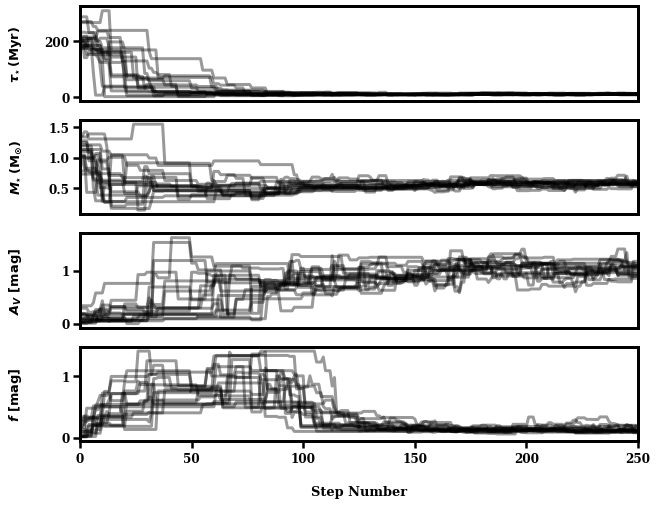

In [29]:
from dsa.radius.plot import time_series

samples = sampler.get_chain()
fig1 = time_series(samples)

Next, we'll look at a corner plot which uses `corner` to plot histograms 2D projections of our stellar parameters. 

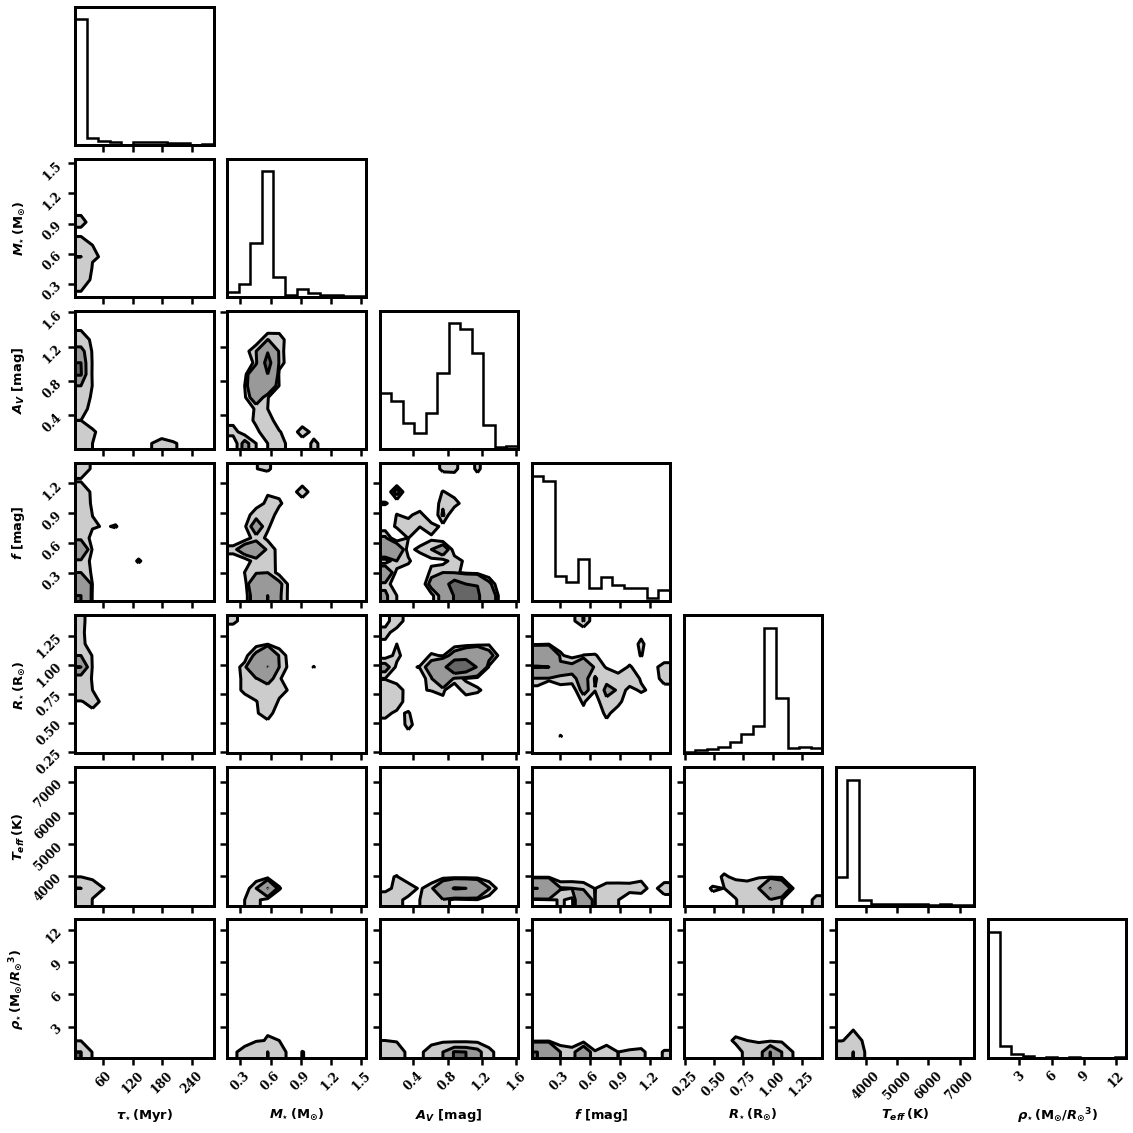

In [30]:
from dsa.radius.plot import corner_plot

fig2 = corner_plot(chains, bins=12)

Lastly, we'll take a look at a flux density vs. wavelength plot which shows the measured flux compared to the median and maximum-probability estimated fluxes. 

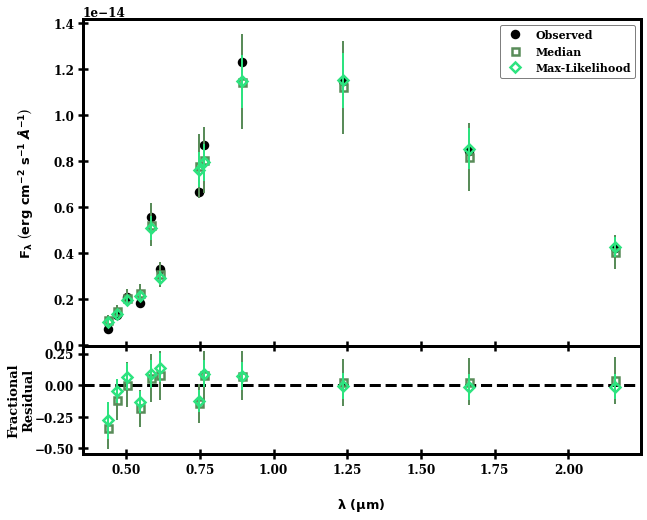

In [31]:
from dsa.radius.plot import flux_v_wavelength

fig3 = flux_v_wavelength(photometry)

Since these plotting functions all return their respective `matplotlib.figure.Figure` objects, we can just as easily save each figure or access any of their attributes.

## Miscellaneous <a id='misc'></a>

### Measured Photometry Kwargs <a id='meas_phot_kwargs'></a>

It is possible to pass a few additional keyword arguments to `Estimate` to better control the photometry-getting, so we'll cover some of them briefly here.

- `search_radius` (float or `astropy.Quantity`) - The initial search radius for the Vizier query. The default is 5 arcseconds.
- `radius_step` (float or `astropy.Quantity`) - How the search radius is decreased every query when it needs to be narrowed down.
- `tol` (int) - Minimum number of magnitudes needed to run the simulation.
- `lazy_tol` (bool) - If `True` (default), will find the search radius where all queried tables contain 1 target. If `False`, will save each table successively once they contain only 1 target (trying to maximize photometry amount).
- `vizier_kwargs`(dict) - Keyword arguments passable to `astroquery.vizier.Vizier` or related methods. See https://astroquery.readthedocs.io/en/lates/api/astroquery.vizier.VizierClass.html#astroquery.vizier.VizierClass for available attributes.
- `validate` (bool) - If `True`, cross-validate the catalog photometry with expected color values via E. E. Mamajek's table https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt . The default is `False`.

### Set Extinction to Zero <a id='zero_extinction'></a>

It is also possible to set extinction to zero for the entire simulation if desired. To do this set `zero_extinction=True` (default is `False`) when initializing the `Estimate` class. This is a useful approximation if you know that there should be little to no extinction for a target. It also has the added benefit of speeding up the code since it does not need to perform the extinction calculation for every walker at every step. 